In [1]:
import matplotlib
import bokeh
import plotly
import sklearn

In [2]:
import os
import findspark

if os.path.isdir("/cluster/home/simondi/spark/"):
    is_cluster = True
    import sparkhpc
    from sparkhpc import sparkjob
    spark_path = "/cluster/home/simondi/spark/"
else:
    is_cluster = False
    spark_path = "/usr/local/spark/spark/"

findspark.init(spark_path)
import pyspark

In [3]:
from pyspark.rdd import reduce
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import SparseVector, VectorUDT, Vector, Vectors

In [10]:
if is_cluster:
    sj = sparkjob.sparkjob(ncores=4)
    sj.wait_to_start()
    sc = sj.start_spark()

Exception: Java gateway process exited before sending the driver its port number

In [4]:
conf = pyspark.SparkConf().setMaster("local[2]")
sc = pyspark.SparkContext(conf=conf)

In [5]:
spark = pyspark.sql.SparkSession(sc)

In [6]:
if is_cluster:
    file_name = "/cluster/home/simondi/simondi/tix/data/screening_data/cells_sample_10.tsv"
else:
    file_name = "/Users/simondi/PHD/data/data/target_infect_x/screening_data_subset/cells_sample_10.tsv"

In [7]:
df = spark.read.csv(path=file_name, sep="\t", header='true')

In [8]:
df.cache()

DataFrame[study: string, pathogen: string, library: string, design: string, replicate: string, plate: string, well: string, gene: string, sirna: string, well_type: string, image_idx: string, object_idx: string, cells.areashape_area: string, cells.areashape_eccentricity: string, cells.areashape_extent: string, cells.areashape_formfactor: string, cells.areashape_majoraxislength: string, cells.areashape_minoraxislength: string, cells.areashape_perimeter: string, cells.children_bacteria_count: string, cells.children_invasomes_count: string, cells.location_center_x: string, cells.location_center_y: string, cells.neighbors_anglebetweenneighbors_2: string, cells.neighbors_firstclosestobjectnumber_2: string, cells.neighbors_firstclosestxvector_2: string, cells.neighbors_firstclosestyvector_2: string, cells.neighbors_numberofneighbors_2: string, cells.neighbors_secondclosestobjectnumber_2: string, cells.neighbors_secondclosestxvector_2: string, cells.neighbors_secondclosestyvector_2: string, ce

In [9]:
old_cols = df.schema.names
new_cols = list(map(lambda x: x.replace(".", "_"),  old_cols))
df = reduce(lambda data, idx: data.withColumnRenamed(old_cols[idx], new_cols[idx]), range(len(new_cols)), df)
for i, x in enumerate(new_cols):
    if x.startswith("cells"):
        df= df.withColumn(x, df[x].cast("double"))

In [10]:
from pyspark.sql.window import Window
import pyspark.sql.functions as func

def z_score_w(col, w):
    avg = func.avg(col).over(w)
    sd = func.stddev(col).over(w)
    return (col - avg) / sd

X = df.sample(fraction=.0001, withReplacement=False)
X.cache()

DataFrame[study: string, pathogen: string, library: string, design: string, replicate: string, plate: string, well: string, gene: string, sirna: string, well_type: string, image_idx: string, object_idx: string, cells_areashape_area: double, cells_areashape_eccentricity: double, cells_areashape_extent: double, cells_areashape_formfactor: double, cells_areashape_majoraxislength: double, cells_areashape_minoraxislength: double, cells_areashape_perimeter: double, cells_children_bacteria_count: double, cells_children_invasomes_count: double, cells_location_center_x: double, cells_location_center_y: double, cells_neighbors_anglebetweenneighbors_2: double, cells_neighbors_firstclosestobjectnumber_2: double, cells_neighbors_firstclosestxvector_2: double, cells_neighbors_firstclosestyvector_2: double, cells_neighbors_numberofneighbors_2: double, cells_neighbors_secondclosestobjectnumber_2: double, cells_neighbors_secondclosestxvector_2: double, cells_neighbors_secondclosestyvector_2: double, ce

In [12]:
import sys
w = Window().partitionBy(["study", "pathogen"]).rowsBetween(-sys.maxsize, sys.maxsize)
for x in X.columns:
    if x.startswith("cells"):
        X = X.withColumn(x, z_score_w(df[x], w))

In [13]:
X=X.na.fill(value=0)

In [14]:
X.count()

534

In [15]:
assembler = VectorAssembler(inputCols=[x for x in X.columns if x.startswith("cells")], outputCol='features')
Y = assembler.transform(X)

In [16]:
Y.cache()

DataFrame[study: string, pathogen: string, library: string, design: string, replicate: string, plate: string, well: string, gene: string, sirna: string, well_type: string, image_idx: string, object_idx: string, cells_areashape_area: double, cells_areashape_eccentricity: double, cells_areashape_extent: double, cells_areashape_formfactor: double, cells_areashape_majoraxislength: double, cells_areashape_minoraxislength: double, cells_areashape_perimeter: double, cells_children_bacteria_count: double, cells_children_invasomes_count: double, cells_location_center_x: double, cells_location_center_y: double, cells_neighbors_anglebetweenneighbors_2: double, cells_neighbors_firstclosestobjectnumber_2: double, cells_neighbors_firstclosestxvector_2: double, cells_neighbors_firstclosestyvector_2: double, cells_neighbors_numberofneighbors_2: double, cells_neighbors_secondclosestobjectnumber_2: double, cells_neighbors_secondclosestxvector_2: double, cells_neighbors_secondclosestyvector_2: double, ce

In [17]:
Y.take(1)

[Row(study='infectx', pathogen='brucella', library='q', design='u', replicate='1', plate='h134-1d', well='b06', gene='cdk2ap1', sirna='si00341971', well_type='sirna', image_idx='268', object_idx='143', cells_areashape_area=-0.1496384995518117, cells_areashape_eccentricity=-0.781055997598137, cells_areashape_extent=1.1041829304532427, cells_areashape_formfactor=1.1505177628103629, cells_areashape_majoraxislength=-0.46244439988977165, cells_areashape_minoraxislength=0.27249212563935, cells_areashape_perimeter=-0.4531963295048056, cells_children_bacteria_count=-0.45268444639838007, cells_children_invasomes_count=0.0, cells_location_center_x=0.5827429505923657, cells_location_center_y=-1.530898365523414, cells_neighbors_anglebetweenneighbors_2=-0.7583408097090323, cells_neighbors_firstclosestobjectnumber_2=-0.04119539864116104, cells_neighbors_firstclosestxvector_2=-1.2217972350357604, cells_neighbors_firstclosestyvector_2=-0.2469645117877445, cells_neighbors_numberofneighbors_2=-0.3479927

In [18]:
Y.rdd.getNumPartitions()

200

In [19]:
kmeans = KMeans(k=5, seed=23)
model = kmeans.fit(Y)

In [21]:
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(Y)

In [22]:
result = pca_model.transform(Y).select("pcaFeatures")

In [23]:
df2 = result.rdd.map(lambda x: tuple(float(x)  for x in x.pcaFeatures.values )).toDF()
df2  = df2.withColumnRenamed("_1", "PCA1")
df2  = df2.withColumnRenamed("_2", "PCA2")

In [24]:
df2 = df2.toPandas()

In [25]:
df2[1:5]

,PCA1,PCA2
1,-1.859919,2.853623
2,0.639531,0.933735
3,-1.966321,0.335287
4,0.485119,0.383243


In [26]:
df2["pathogen"] = Y.select("pathogen").toPandas()
df2["design"] = Y.select("design").toPandas()
df2["library"] = Y.select("library").toPandas()

In [27]:
df2[1:5]

,PCA1,PCA2,pathogen,design,library
1,-1.859919,2.853623,brucella,u,q
2,0.639531,0.933735,brucella,u,q
3,-1.966321,0.335287,brucella,p,d
4,0.485119,0.383243,brucella,p,d


In [28]:
from cycler import cycler
import matplotlib
import matplotlib.pyplot

fig, ax = matplotlib.pyplot.subplots()
matplotlib.pyplot.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y'])))
ax.margins(0.05)

groups = df2.groupby("pathogen")
for name, group in groups:
    design_groups = group.groupby(['design'])
    for design, dgr in design_groups:
        ax.plot(dgr.PCA1, dgr.PCA2, marker='o', linestyle='', ms=5, label=name +", "+ design)
ax.legend()
pylab.savefig('foo.png')

RuntimeError: Invalid DISPLAY variable

In [209]:
import sklearn

In [210]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import manifold
from sklearn.utils import check_random_state

In [221]:
df2.values

array([[  2.91520086e+00,  -3.70741153e-01],
       [  4.73659559e-01,   2.27861800e-01],
       [  1.33011051e+00,  -5.44508449e-01],
       ..., 
       [  2.20676574e+00,   2.07656888e+00],
       [  1.75356132e-01,  -7.02102822e-01],
       [ -8.58140567e-04,   6.66606044e-01]])

In [226]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
trans_data = tsne.fit_transform(df2.values)



In [241]:
transe=pandas.DataFrame(trans_data)
transe["pathogen"] = Y.select("pathogen").toPandas()
transe["design"] = Y.select("design").toPandas()
transe.columns = ['a', 'b', 'pathogen', 'design']
transe

,a,b,pathogen,design
0,-16.388256,0.329523,brucella,u
1,-2.649010,0.699221,brucella,u
2,-9.178353,-3.934992,brucella,u
3,3.702672,-11.588075,brucella,p
4,-12.038499,-6.845116,brucella,p
5,6.679056,6.014356,brucella,u
6,-13.188291,6.432633,brucella,p
7,8.717917,10.688834,brucella,u
8,-1.530753,-8.306866,brucella,u
9,9.237120,-11.571178,brucella,u


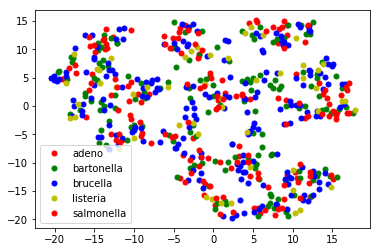

In [250]:
fig, ax = matplotlib.pyplot.subplots()
matplotlib.pyplot.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y'])))
ax.margins(0.05)

groups = transe.groupby("pathogen")
for name, group in groups:
        ax.plot(group.a, group.b, marker='o', linestyle='', ms=5, label=name)
ax.legend()
matplotlib.pyplot.show()

In [12]:

sc.stop()